In [1]:
import pandas
import numpy
import sqlite3 as sql
import seaborn as sns
import math
import matplotlib.pyplot as plt
import os
import sys
import datetime
from ast import literal_eval
sys.path.insert(0, os.path.abspath('../source'))
from graph import Graph as MyGraph

sns.set()
figsize = (12, 8)
db = sql.connect('../source/database.db')
where_clause = ('SETTINGS.organizational_experiment = "test2502"')
                #' OR SETTINGS.organizational_experiment = "basic_linear_trivial"'
                #' OR SETTINGS.organizational_experiment = "basic_linear_second_order"')

# Code

In [2]:
class Pipeline:
    def __init__(self, name=None):
        self.name = name
        if name is None:
            self.name = "default_" + datetime.datetime.now().strftime('%Y%m%H%M')
        self.alphas = pandas.read_sql_query(f'SELECT RESULTS.*, GRAPHS.technical, SETTINGS.organizational_experiment FROM RESULTS INNER JOIN SETTINGS, GRAPHS ON RESULTS.settings_id = SETTINGS.settings_id AND RESULTS.graph_id = GRAPHS.id WHERE {where_clause}', db)
        assert self.alphas.empty == False, "No results available for given filter"
        run_columns = ["organizational_experiment", "model_accuracy", "model_accuracies", "model_loss", "model_losses", "execution_start", "execution_end", "epoch_avg_runtime"]
        self.runs = self.alphas.drop_duplicates(run_columns)[run_columns]
        self.runs["model_losses"] = self.runs["model_losses"].apply(lambda x: literal_eval(x))
        self.runs["model_accuracies"] = self.runs["model_accuracies"].apply(lambda x: literal_eval(x))
        self.runs["dummy"] = self.runs["organizational_experiment"].apply(lambda x: '')
        self.graphs = self.alphas[["organizational_experiment", "graph_id", "technical", "graph_alpha"]].groupby(["organizational_experiment", "graph_id", "technical"]).mean().sort_values("graph_alpha").reset_index()
        labels = dict(zip(self.graphs["graph_id"].drop_duplicates(), self.graphs.index))
        self.alphas["graph_label"] = self.alphas.apply (lambda row: f'Graph {labels[row["graph_id"]]}', axis=1)
        
    def global_ax_properties(self, ax):
        ax.legend(loc='upper right')
    
    def show_runs(self):
        print(self.runs[['organizational_experiment', 'dummy']].groupby(by='organizational_experiment').count()
             .rename(columns={'dummy': 'count'}))
    
    def show_model_metrics(self):
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.tight_layout()
        for spec, ax in zip([{'column': 'model_accuracy', 'label': 'Accuracy'},
                           {'column': 'model_loss', 'label': 'Loss'},
                           {'column': 'epoch_avg_runtime', 'label': 'Average epoch runtime (s)'}], axes.reshape(-1)):
            sns.boxplot(ax=ax, x=self.runs['dummy'], y=self.runs[spec['column']],
                        hue=self.runs['organizational_experiment'])
            self.global_ax_properties(ax)
            ax.set_title(spec['label'])
            ax.set_ylabel(spec['label'])
            ax.set_xlabel('')
        
    def learning_curve(self):
        def _get_timeseries(row, key):
            return list(row[key])
        
        def _get_df(key):
            values = []
            indices = []
            hue = []
            for _, row in self.runs.iterrows():
                values.extend(_get_timeseries(row, key))
                indices.extend(range(len(_get_timeseries(row, key))))
                hue.extend([row['organizational_experiment'] for i in range(len(_get_timeseries(row, key)))])
            return pandas.DataFrame({'hue': hue, 'indices': indices, 'values': values})
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.tight_layout()
        for spec, ax in zip([{'column': 'model_losses', 'title': 'Loss curve', 'label': 'Loss'},
                            {'column': 'model_accuracies', 'title': 'Accuracy curve', 'label': 'Accuracy'}],
                            axes.reshape(-1)):
            sns.lineplot(ax=ax, data=_get_df(spec['column']), x="indices", y="values", hue="hue", estimator="median", ci='sd')
            self.global_ax_properties(ax)
            ax.set_title(spec['title'])
            ax.set_ylabel(spec['label'])
            ax.set_xlabel('Epochs')
        
    def show_graphs(self):
        _, axes = plt.subplots(math.ceil(len(self.graphs) / 3), 3, figsize=figsize)
        graphs = self.graphs.drop_duplicates(["graph_id"])
        for i, ax in zip(range(len(graphs)), axes.reshape(-1)):
            MyGraph(graphs["graph_id"].iloc[i], graphs["technical"].iloc[i]).visualize(ax)
            ax.set_title(f"Graph {i}")
        #plt.savefig(f"{self.name}_graphs.png")
            
    def show_alphas(self):
        ax = sns.boxplot(x="graph_label", y="graph_alpha", hue="organizational_experiment", data=self.alphas.sort_values(["graph_label"]))
        self.global_ax_properties(ax)
        ax.set_ylabel('Alpha Density')
        ax.set_xlabel('')
        #plt.savefig(f"{self.name}_alphas.png")

In [3]:
pipeline = Pipeline()

# Visualizations

## Number runs

In [4]:
pipeline.show_runs()

                           count
organizational_experiment       
test2502                       3


## Model metrics

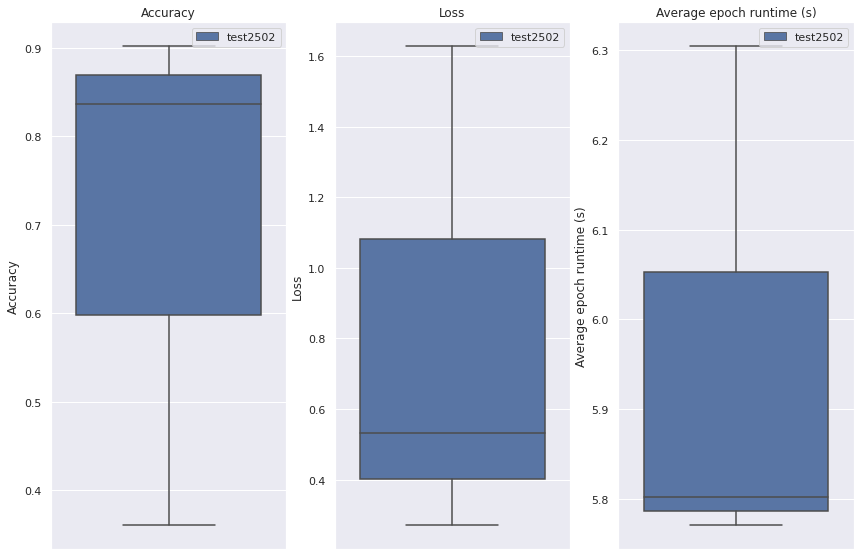

In [5]:
pipeline.show_model_metrics()

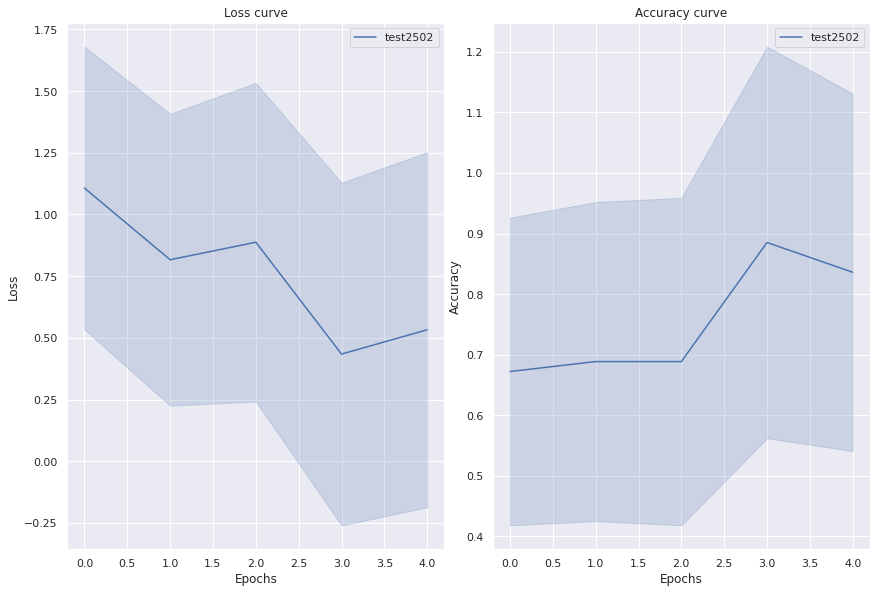

In [6]:
pipeline.learning_curve()

## Graphs

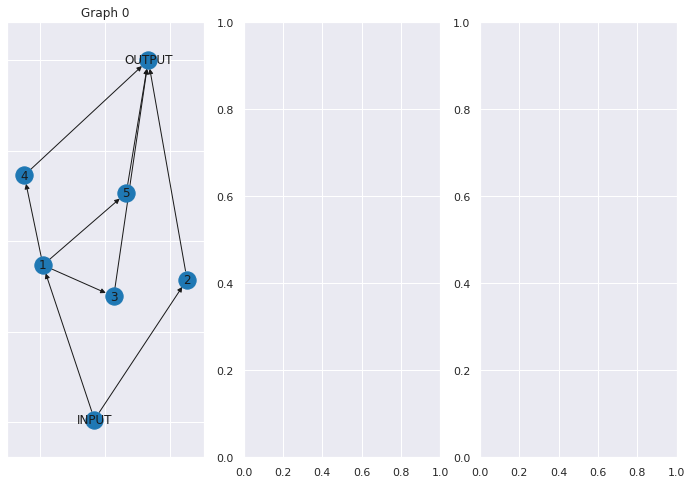

In [7]:
pipeline.show_graphs()

## Alphas

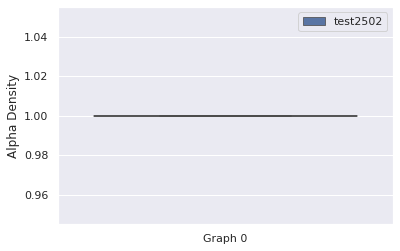

In [8]:
pipeline.show_alphas()